# MAP estimation

Here, we give an example of how to compute the joint maximum a posteriori (MAP) estimate of the CMB temperature and polarization fields, $f$, and the lensing potential, $\phi$.

In [1]:
using CMBLensing, PyPlot

## Compute spectra

First, we compute the fiducial CMB power spectra which generate our simulated data,

In [2]:
Cℓ = camb(r=0.05);

Next, we chose the noise power-spectra:

In [3]:
Cℓn = noiseCℓs(μKarcminT=1, ℓknee=100);

Plot these up for reference,

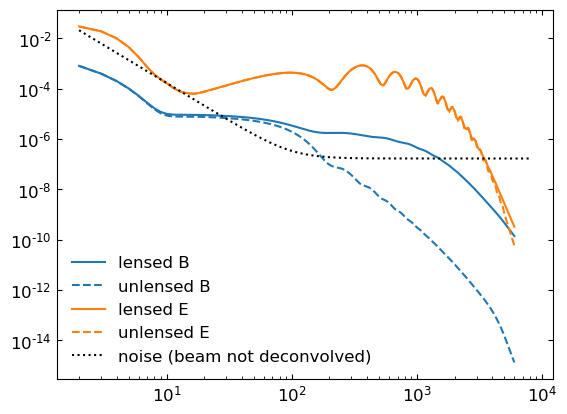

In [4]:
loglog(Cℓ.total.BB,c="C0")
loglog(Cℓ.unlensed_total.BB,"--",c="C0")
loglog(Cℓ.total.EE,c="C1")
loglog(Cℓ.unlensed_total.EE,"--",c="C1")
loglog(Cℓn.BB,"k:")
legend(["lensed B","unlensed B","lensed E","unlensed E", "noise (beam not deconvolved)"]);

## Configure the type of data

These describe the setup of the simulated data we are going to work with (and can be changed in this notebook),

In [5]:
θpix  = 3        # pixel size in arcmin
Nside = 128      # number of pixels per side in the map
pol   = :P       # type of data to use (can be :T, :P, or :TP)
T     = Float32  # data type (Float32 is ~2 as fast as Float64);

## Generate simulated data

With these defined, the following generates the simulated data and returns the true unlensed and lensed CMB fields, `f` and `f̃` ,and the true lensing potential, `ϕ`, as well as a number of other quantities stored in the "DataSet" object `ds`. 

In [6]:
@unpack f, f̃, ϕ, ds = load_sim_dataset(
    seed = 3,
    Cℓ = Cℓ,
    Cℓn = Cℓn,
    θpix = θpix,
    T = T,
    Nside = Nside,
    pol = pol,
)

@unpack Cf, Cϕ = ds;

## Examine simulated data

The true $\phi$ map,

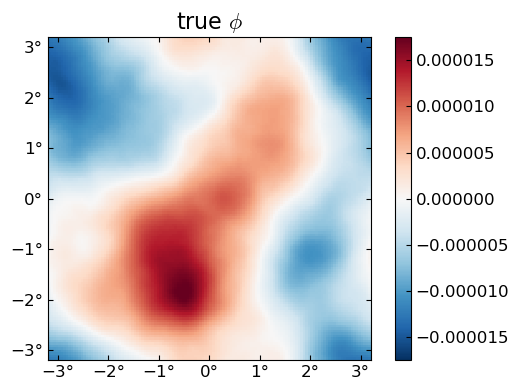

In [7]:
plot(ϕ, title = raw"true $\phi$");

The "true" unlensed field, $f$,

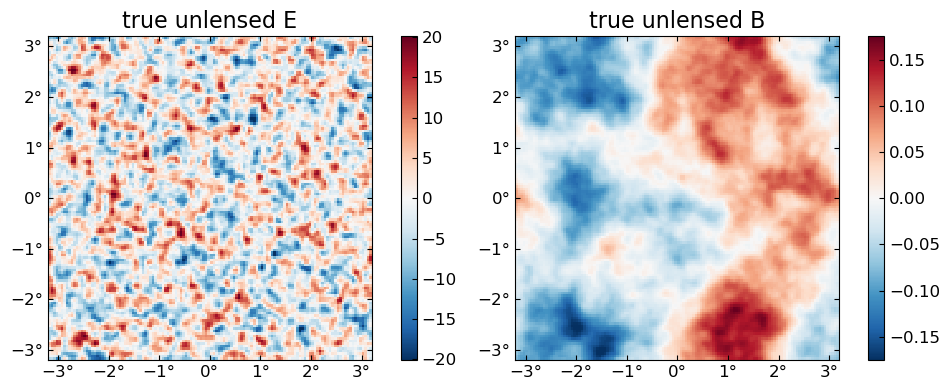

In [8]:
plot(f, title = "true unlensed " .* ["E" "B"]);

And the "true" lensed field,

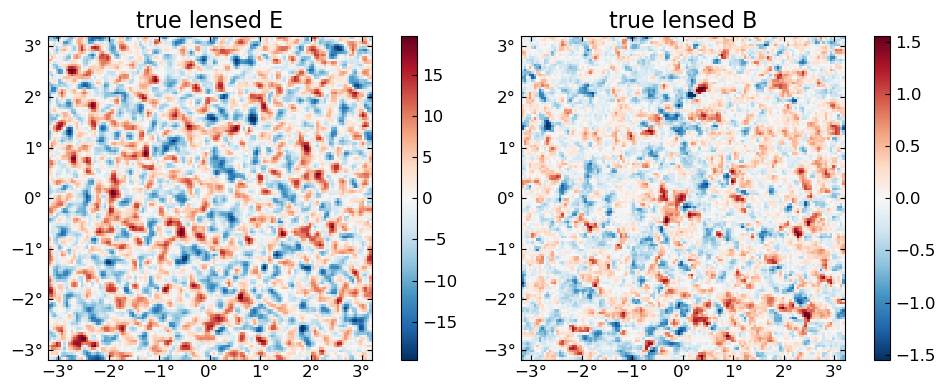

In [9]:
plot(LenseFlow(ϕ)*f, title = "true lensed " .* ["E" "B"]);

The data (stored in the `ds` object) is basically `f̃` with a beam applied plus a sample of the noise,

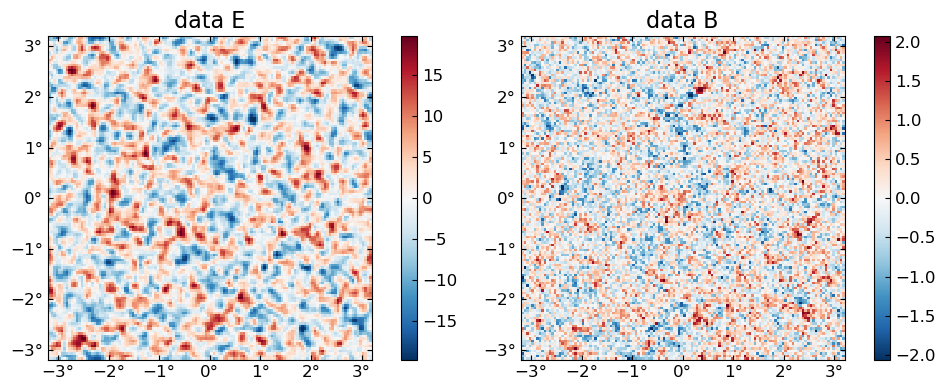

In [10]:
plot(ds.d, title = "data " .* ["E" "B"]);

# Run the optimizer

Now we compute the maximum of the joint posterior, $\mathcal{P}\big(f, \phi \,\big|\,d\big)$

In [11]:
@time fbf, ϕbf, tr = MAP_joint(ds, nsteps=30, progress=:verbose, αmax=0.1);

(step=1, χ²=43835.08, Ncg=2)
(step=2, χ²=38139.01, Ncg=11, α=0.015414)
(step=3, χ²=36517.02, Ncg=8, α=0.020852)
(step=4, χ²=35831.12, Ncg=9, α=0.015954)
(step=5, χ²=35364.19, Ncg=8, α=0.023302)
(step=6, χ²=35070.12, Ncg=9, α=0.015335)
(step=7, χ²=34820.65, Ncg=8, α=0.026114)
(step=8, χ²=34647.73, Ncg=8, α=0.014320)
(step=9, χ²=34480.42, Ncg=8, α=0.030749)
(step=10, χ²=34361.68, Ncg=8, α=0.012965)
(step=11, χ²=34224.91, Ncg=7, α=0.041680)
(step=12, χ²=34131.42, Ncg=7, α=0.011439)
(step=13, χ²=33980.97, Ncg=7, α=0.077469)
(step=14, χ²=33890.13, Ncg=7, α=0.009903)
(step=15, χ²=33731.25, Ncg=5, α=0.099927)
(step=16, χ²=33710.55, Ncg=6, α=0.020428)
(step=17, χ²=33692.20, Ncg=6, α=0.016306)
(step=18, χ²=33674.08, Ncg=6, α=0.021583)
(step=19, χ²=33658.31, Ncg=6, α=0.015283)
(step=20, χ²=33641.89, Ncg=6, α=0.024106)
(step=21, χ²=33627.96, Ncg=6, α=0.013958)
(step=22, χ²=33612.39, Ncg=6, α=0.028650)
(step=23, χ²=33599.56, Ncg=6, α=0.012576)
(step=24, χ²=33583.64, Ncg=6, α=0.037295)
(step=25, χ²

# Examine results

The expected value of the final best-fit $\chi^2 (=-2\log \mathcal{P}$) is given by the number degrees of freedom in the data, i.e. the total number of pixels in T and/or EB.

In [12]:
χ² = -2tr[end][:lnPcur]

33487.44f0

In [13]:
dof = length(Map(f)[:])

32768

Here's how far away our final $\chi^2$ is from this expectation, in units of $\sigma$. We expect this should be somewhere in the range (-3,3) for about 99.7% of simulated datasets.

In [14]:
(χ² - dof)/sqrt(2dof)

2.8103179931640625

Here's the best-fit $\phi$ relative to the truth,

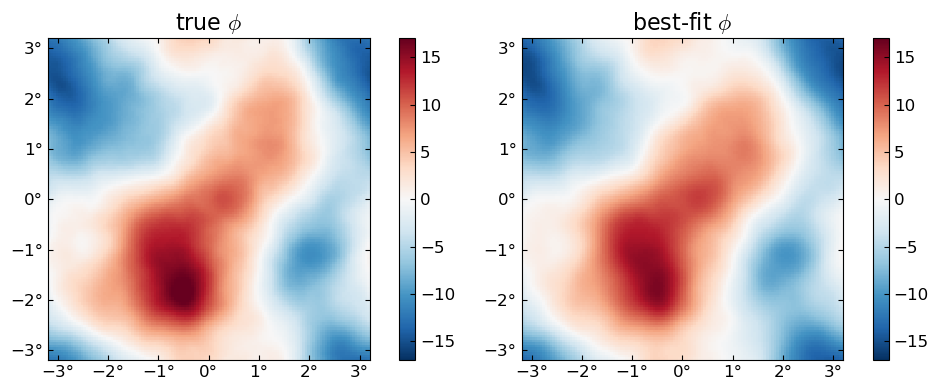

In [15]:
plot(10^6*[ϕ ϕbf], title=["true" "best-fit"] .* raw" $\phi$", vlim=17);

Here is the difference in terms of the power spectra. Note the best-fit has high-$\ell$ power suppressed, like a Wiener filter solution (in fact what we're doing here is akin to a non-linear Wiener filter). In the high S/N region ($\ell\lesssim1000$), the difference is approixmately equal to the noise, which you can see is almost two orders of magnitude below the signal.

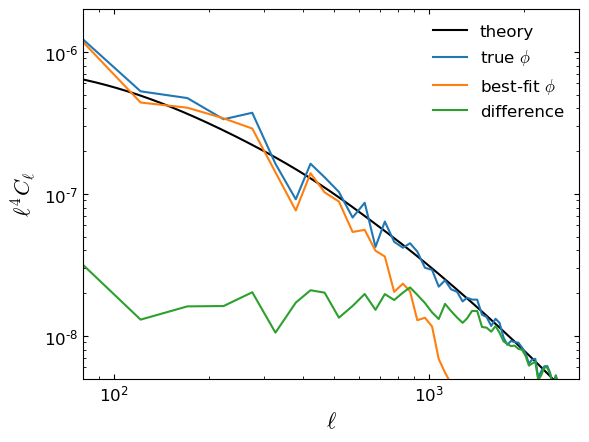

In [16]:
loglog(ℓ⁴ * Cℓ.total.ϕϕ, "k")
loglog(get_ℓ⁴Cℓ(ϕ))
loglog(get_ℓ⁴Cℓ(ϕbf))
loglog(get_ℓ⁴Cℓ(ϕbf-ϕ))
xlim(80,3000)
ylim(5e-9,2e-6)
legend(["theory",raw"true $\phi$", raw"best-fit $\phi$", "difference"])
xlabel(raw"$\ell$")
ylabel(raw"$\ell^4 C_\ell$");

The best-fit unlensed fields relative to truth,

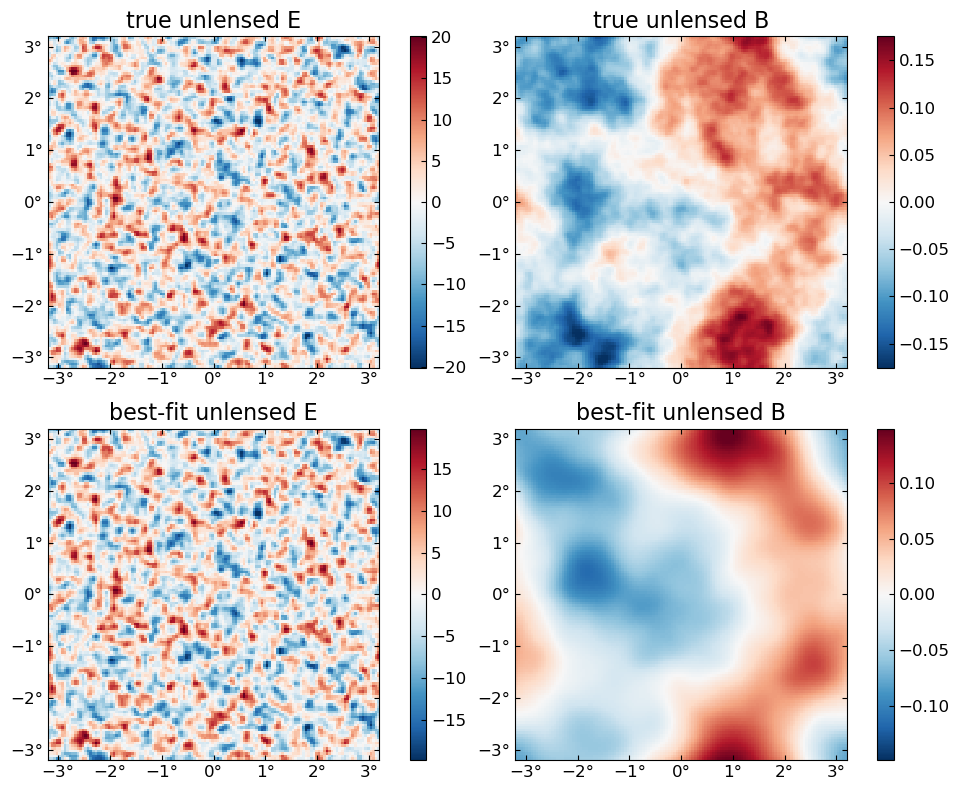

In [17]:
plot([f,fbf], title = ["true", "best-fit"] .* " unlensed " .* ["E" "B"]);

The best-fit lensed field (bottom row) relative to truth (top row),

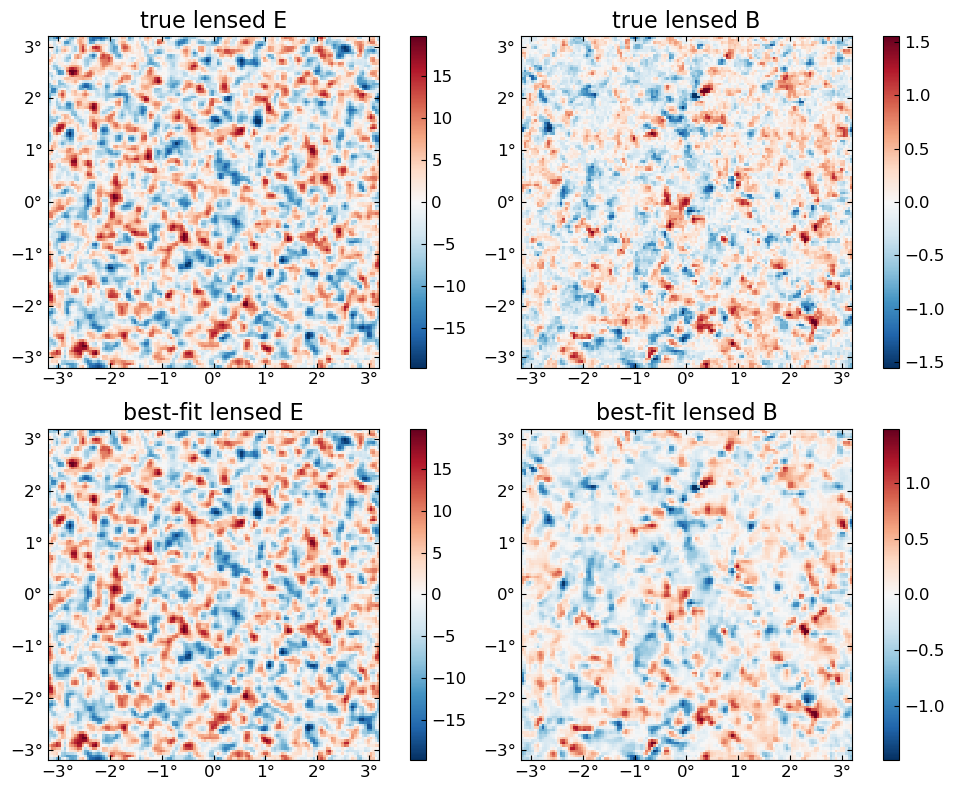

In [18]:
plot([f̃, LenseFlow(ϕbf)*fbf], title = ["true", "best-fit"] .* " lensed " .* ["E" "B"]);